<a href="https://colab.research.google.com/github/pati-dev/predict-shopping-intention/blob/master/predict_purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boot

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Load Data

In [0]:
shop = pd.read_csv("/content/drive/My Drive/Personal/IUB/Job apps/Capgemini/online_shoppers_intention.csv")

In [7]:
shop.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Data preprocessing

In [101]:
print(shop.columns)
print(shop.dtypes)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


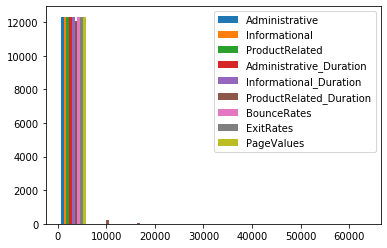

In [83]:
pages = ['Administrative',
         'Informational',
         'ProductRelated',
         'Administrative_Duration',
         'Informational_Duration',
         'ProductRelated_Duration',
         'BounceRates',
         'ExitRates',
         'PageValues']

x_pages = shop.loc[:, pages].values

plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

### Feature scaling

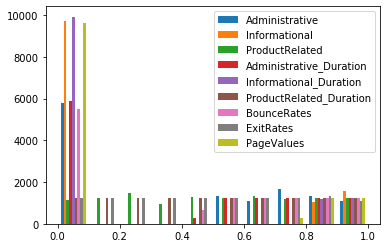

In [84]:
x_pages = QuantileTransformer(output_distribution='uniform').fit_transform(x_pages)
plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

### Dimension reduction

% variance explained: 87.30159663473717


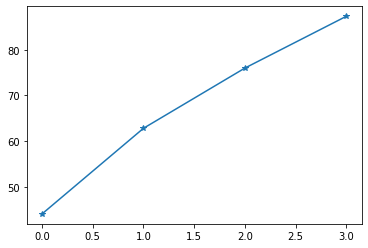

In [98]:
pca = PCA(n_components=4)

pca.fit(x_pages)

print("% variance explained:", sum(pca.explained_variance_ratio_)*100)
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(variance, marker='*')
plt.show()

# Modeling

## Prepare data

In [0]:
pages_pca = pca.fit_transform(x_pages)

df_pages_pca = pd.DataFrame(data = pages_pca,
                            columns = ['pages_pc1',
                                       'pages_pc2',
                                       'pages_pc3',
                                       'pages_pc4'])

shop['is_weekend'] = np.where(shop['Weekend']==True, 1, 0)
shop['returning_visitor'] = np.where(shop['VisitorType']=="Returning_Visitor", 1, 0)
shop['purchase'] = np.where(shop['Revenue']==True, 1, 0)

cols = ['is_weekend',
        'returning_visitor',
        'SpecialDay',
        'purchase']
df_shop = shop.loc[:, cols]

df_final = pd.concat([df_pages_pca, df_shop], axis=1)

In [0]:
features = ['pages_pc1',
            'pages_pc2',
            'pages_pc3',
            'pages_pc4',
            'is_weekend',
            'returning_visitor',
            'SpecialDay']
x, y = df_final.loc[:, features], df_final['purchase']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [125]:
lr_model = LogisticRegression()

# penalty = ['l1', 'l2']
solver = ['lbfgs', 'newton-cg']
C = np.logspace(0, 4, 10)

hyperparams = dict(solver=solver,
                   C=C)

clf = GridSearchCV(lr_model, hyperparams, cv=5)
model = clf.fit(x_train, y_train)

print('Best solver:', model.best_estimator_.get_params()['solver'])
print('Best C:', model.best_estimator_.get_params()['C'])

Best solver: lbfgs
Best C: 1.0


In [128]:
predictions = model.predict(x_test)

acc = model.score(x_test, y_test)
print("Accuracy:", acc)

M = metrics.confusion_matrix(y_test, predictions)
n_samples = len(y_test)
print(M)
print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))

Accuracy: 0.8683427953500946
[[2951  126]
 [ 361  261]]
Accuracy:  0.87
Precision: 0.67
Recall:    0.42
